In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# 1. Tiền xử lý dữ liệu

In [ ]:
project_url = '../../../../source/DU_AN_CNTT_2/'
project_url = glob.glob(project_url)[0]
path = os.path.join(project_url, 'Data/d1/diabetes_012_health_indicators_BRFSS2021_cleaned.csv')
df = pd.read_csv(path)
df

,Class,BMI,MentHlth,PhysHlth
0,2,28.0,0,0
1,2,33.0,10,0
2,2,29.0,0,30
3,0,24.0,0,0
4,0,40.0,5,25
...,...,...,...,...
14598,0,25.0,21,4
14599,0,28.0,1,28
14600,2,40.0,28,20
14601,1,41.0,7,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14603 entries, 0 to 14602
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Class     14603 non-null  int64  
 1   BMI       14603 non-null  float64
 2   MentHlth  14603 non-null  int64  
 3   PhysHlth  14603 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 456.5 KB


## 1.1 Train Test split và normalize

### 1.1.1 Train Test Split

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X, y = df.drop(columns=['Class']), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.value_counts().sort_index()

,count
Class,
0,6611
1,1367
2,3704


### 1.1.2. Normalize

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
y_train.value_counts().sort_index()

,count
Class,
0,6611
1,1367
2,3704


### 1.1.3. Kết quả và lưu tập dữ liệu trước cân bằng

In [60]:
origin = np.concatenate((y_train.values.reshape(-1,1), X_train,), axis=1)
origin = pd.DataFrame(origin, columns=df.columns)
# origin = origin.sample(frac = 0.8, random_state = 42)
path = os.path.join(project_url, f'Data/d1/Balanced Data/origin.csv')
origin.to_csv(path, index=False)

In [61]:
train = np.concatenate((y_train.values.reshape(-1,1), X_train,), axis=1)
train = pd.DataFrame(train, columns=df.columns)
train.value_counts('Class').sort_index()

,count
Class,
0.0,6611
1.0,1367
2.0,3704


## 1.2 Can Bang

### Balance

In [62]:
X_train, y_train = train.drop('Class', axis=1), train['Class']
y_train.value_counts().sort_index()

,count
Class,
0.0,6611
1.0,1367
2.0,3704


In [63]:
from imblearn.over_sampling import SMOTE, SMOTENC, KMeansSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

In [64]:
methods = [
    SMOTE(sampling_strategy='not majority',k_neighbors=3, random_state=42),
    # SMOTENC(sampling_strategy='all', categorical_features=ncols, k_neighbors=3, random_state=42),
    ADASYN(sampling_strategy='auto', random_state = 42, n_neighbors=3),
    NearMiss(sampling_strategy='not minority', n_neighbors=2),
    TomekLinks(sampling_strategy='auto'),
    EditedNearestNeighbours(sampling_strategy= 'not minority'),
    SMOTEENN(
        smote = SMOTE(
            sampling_strategy='all',
            k_neighbors=3),
        enn = EditedNearestNeighbours(sampling_strategy= 'all')
                          ),
    SMOTETomek(
        smote = SMOTE(
            sampling_strategy='not majority',
            k_neighbors=3,
            random_state=42
            ),
        tomek = TomekLinks(sampling_strategy='auto')
                          )
]

In [65]:
samples = []
names = ['SMOTE', 'ADASYN', 'NearMiss', 'TomekLinks', 'ENN', 'SMOTEENN', 'SMOTETomek']
c = 0
# beta = 0.3
for method in methods:
    # if names[c] == 'NearMiss':
    #     X_train_02 = X_train.loc[y_train!=1].copy()
    #     y_train_02 = y_train.loc[y_train!=1].copy()
    #     X_train_resample, y_train_resample = method.fit_resample(X_train_02, y_train_02)
    #     X_train_resample = pd.concat([X_train_resample, X_train.loc[y_train==1]])
    #     y_train_resample = pd.concat([y_train_resample, y_train.loc[y_train==1]])
    # else:
    X_train_resample, y_train_resample = method.fit_resample(X_train, y_train)
    sample = np.concatenate((y_train_resample.values.reshape(-1,1), X_train_resample,), axis=1)
    sample = pd.DataFrame(sample, columns=df.columns)
    # sample = sample.sample(frac = 0.8, random_state = 42)
    print(sample.value_counts('Class').sort_index().to_list())
    samples.append(sample)
    print(f'Resampling dataset by {names[c]} done.')
    c += 1

[6611, 6611, 6611]
Resampling dataset by SMOTE done.
[6611, 6350, 6257]
Resampling dataset by ADASYN done.
[1367, 1367, 1367]
Resampling dataset by NearMiss done.
[6237, 1367, 3369]
Resampling dataset by TomekLinks done.
[1530, 1367, 81]
Resampling dataset by ENN done.
[1257, 1774, 931]
Resampling dataset by SMOTEENN done.
[6611, 6132, 5965]
Resampling dataset by SMOTETomek done.


In [66]:
# Lưu các mẫu dữ liệu đã được cân bằng
c = 0
for sample in samples:
    path = os.path.join(project_url, f'Data/d1/Balanced Data/{names[c]}.csv')
    sample.to_csv(path, index=False)
    c += 1
    print(f'Saved {names[c-1]}.')

Saved SMOTE.
Saved ADASYN.
Saved NearMiss.
Saved TomekLinks.
Saved ENN.
Saved SMOTEENN.
Saved SMOTETomek.


In [67]:
test = np.concatenate((y_test.values.reshape(-1,1), X_test,), axis=1)
test = pd.DataFrame(test, columns=df.columns)
path = os.path.join(project_url, f'Data/d1/test.csv')
test.to_csv(path, index=False)

# 2. Test

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, accuracy_score, confusion_matrix

## 2.1 Tập trước cân bằng

In [69]:
X_origin, y_origin = origin.drop('Class', axis=1), origin['Class']
y_origin.value_counts().sort_index()

,count
Class,
0.0,6611
1.0,1367
2.0,3704


In [70]:
rf = RandomForestClassifier(
        n_estimators=100,
        criterion='entropy',
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=3,
        random_state=42,
        max_features=17
    )
rf.fit(X_origin, y_origin)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=17, min_samples_leaf=3,
                       random_state=42)

In [71]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [72]:
precision_score(y_test, y_pred, average = None)

array([0.66745469, 0.17040951, 0.32402235])

In [73]:
recall_score(y_test, y_pred, average = None)

array([0.50748951, 0.38738739, 0.31556039])

In [74]:
f1_score(y_test, y_pred, average = None)

array([0.57658271, 0.23669725, 0.31973539])

In [75]:
roc_auc_score(y_test, y_prob, multi_class='ovr', average=None)

array([0.62179363, 0.62014739, 0.49391142])

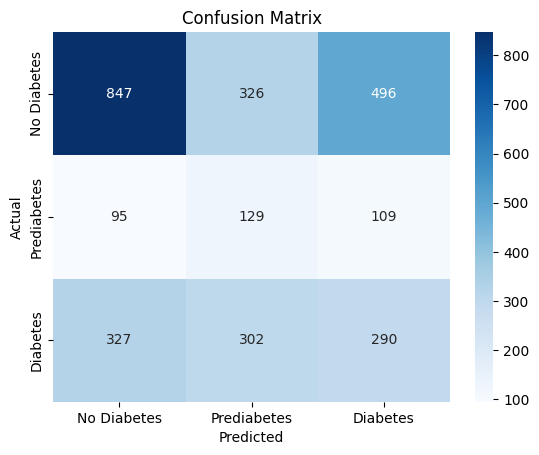

In [76]:
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            yticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2.2. SMOTE

In [85]:
X_train_resample, y_train_resample = samples[0].drop('Class', axis=1), samples[0]['Class']
y_train_resample.value_counts().sort_index()

,count
Class,
0.0,6611
1.0,6611
2.0,6611


In [86]:
rf = RandomForestClassifier(
        n_estimators=100,
        criterion='entropy',
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=3,
        random_state=42,
        max_features=17
    )
rf.fit(X_train_resample, y_train_resample)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=17, min_samples_leaf=3,
                       random_state=42)

In [87]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [88]:
precision_score(y_test, y_pred, average = None)

array([0.65538462, 0.20532319, 0.34063927])

In [89]:
recall_score(y_test, y_pred, average = None)

array([0.51048532, 0.32432432, 0.40587595])

In [90]:
f1_score(y_test, y_pred, average = None)

array([0.57393062, 0.25145518, 0.37040715])

In [91]:
roc_auc_score(y_test, y_prob, multi_class='ovr', average=None)

array([0.61386096, 0.62651252, 0.50288667])

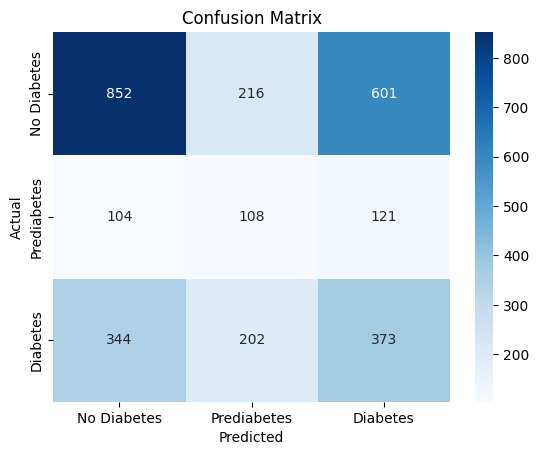

In [92]:
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            yticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            annot=True, fmt='d', cmap='Blues'
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2.3 ENN

In [95]:
X_train_resample, y_train_resample = samples[4].drop('Class', axis=1), samples[4]['Class']
y_train_resample.value_counts().sort_index()

,count
Class,
0.0,1530
1.0,1367
2.0,81


In [96]:
rf = RandomForestClassifier(
        n_estimators=100,
        criterion='entropy',
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=3,
        random_state=42,
        max_features=11
    )
rf.fit(X_train_resample, y_train_resample)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=11, min_samples_leaf=3,
                       random_state=42)

In [97]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [98]:
precision_score(y_test, y_pred, average = None)

array([0.68766178, 0.15456821, 0.42073171])

In [99]:
recall_score(y_test, y_pred, average = None)

array([0.47753146, 0.74174174, 0.07508161])

In [100]:
f1_score(y_test, y_pred, average = None)

array([0.56364922, 0.255826  , 0.12742382])

In [101]:
roc_auc_score(y_test, y_prob, multi_class='ovr', average=None)

array([0.63715168, 0.66802428, 0.55585954])

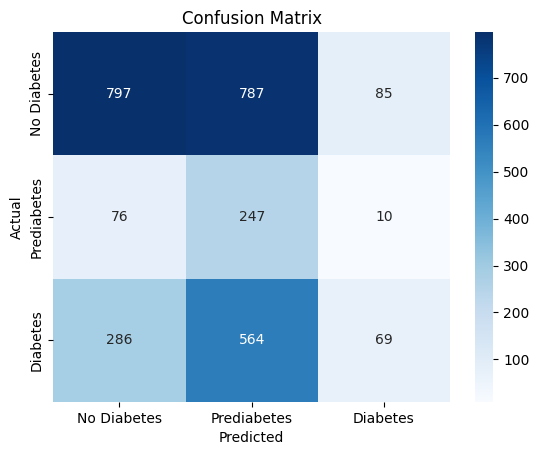

In [102]:
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            yticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2.4 SMOTE-ENN

In [103]:
X_train_resample, y_train_resample = samples[-2].drop('Class', axis=1), samples[-2]['Class']
y_train_resample.value_counts().sort_index()

,count
Class,
0.0,1257
1.0,1774
2.0,931


In [104]:
rf = RandomForestClassifier(
        n_estimators=100,
        criterion='entropy',
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=3,
        random_state=42,
        max_features=17
    )
rf.fit(X_train_resample, y_train_resample)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=17, min_samples_leaf=3,
                       random_state=42)

In [105]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [106]:
precision_score(y_test, y_pred, average = None)

array([0.69022265, 0.1772009 , 0.34830339])

In [107]:
recall_score(y_test, y_pred, average = None)

array([0.42720192, 0.47147147, 0.37976061])

In [108]:
f1_score(y_test, y_pred, average = None)

array([0.52775722, 0.25758819, 0.36335242])

In [109]:
roc_auc_score(y_test, y_prob, multi_class='ovr', average=None)

array([0.62986029, 0.62972381, 0.54435717])

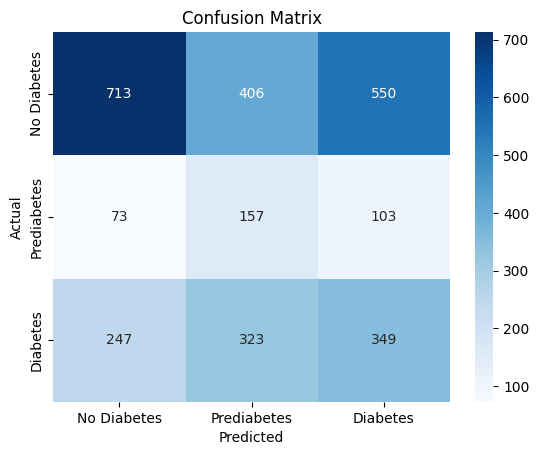

In [110]:
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            yticklabels=['No Diabetes', "Prediabetes", 'Diabetes'],
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. KẾT QUẢ

In [111]:
def sort(data):
    for i in range(len(data)-1):
        for j in range(i+1, len(data)):
            if data[i] < data[j]:
                data[i], data[j] = data[j], data[i]
    return data

In [112]:
samples_ = samples.copy()
samples_.insert(0, origin)
samples_.insert(1, test)
names_ = names.copy()
names_.insert(0, 'Origin')
names_.insert(1, 'Test')
result1 = []
for i in range(len(samples_)):
    d = samples_[i].value_counts('Class').sort_index().to_list()
    temp = d.copy()
    d_reorder = sort(d)
    m = sum(d_reorder)/3
    n = m/10
    major = [i for i in d_reorder if i >= m+n]
    minor = [i for i in d_reorder if i <= m-n]
    if np.sum(major) == 0 or d_reorder[0]-d_reorder[-1] < 1000:
        major = d_reorder[:2]
        minor = d_reorder[-2:]
    IR = np.round(np.sum(major)/np.sum(minor),2)
    result1.append(temp)
    result1[-1].append(IR)
    result1[-1].insert(0, names_[i])
result1 = pd.DataFrame(result1, columns=['Method', 'No Diabetes','Prediabetes', 'Diabetes', 'IR'])
result1.index = result1.Method
result1.drop('Method', axis = 1, inplace = True)
path = os.path.join(project_url, 'Result/d1/DataCounts.csv')
result1.to_csv(path)
result1

,No Diabetes,Prediabetes,Diabetes,IR
Method,,,,
Origin,6611,1367,3704,4.84
Test,1669,333,919,5.01
SMOTE,6611,6611,6611,1.00
ADASYN,6611,6350,6257,1.03
NearMiss,1367,1367,1367,1.00
TomekLinks,6237,1367,3369,4.56
ENN,1530,1367,81,35.77
SMOTEENN,1257,1774,931,1.39
SMOTETomek,6611,6132,5965,1.05


In [113]:
result2 = result1[(result1.index == 'Origin') | (result1.index == 'Test')]
result2.index = ['Train', 'Test']
path = os.path.join(project_url, 'Result/d1/TrainTestCounts.csv')
result2.to_csv(path)
result2

,No Diabetes,Prediabetes,Diabetes,IR
Train,6611,1367,3704,4.84
Test,1669,333,919,5.01
